## 2D springs

This is an attempt to solve the equilibrium for a system of springs and nodes, using a Newton method found here: https://cs.nyu.edu/~dzorin/numcomp08/springs_notes.pdf

At this stage, the system is pretty unstable for meshes larger than about 10 X 10. I tried using a kind of naive multigrid to provide starting guesses for higher resoltions. John Mansour suggested that reverting to Picard iterations may be worthwhile, at least for the first couple of interations in the solve. 

In [200]:
# %load scripts/myarray.py
from numpy import *

# a small set of helper functions to
# call common array creation functions
# these are useful to ensure that
# all arrays are created as double-precision
# floats, no matter what data are provided
# as argument. For example array([1,3,4]) normally returns
# an array with data of type int, but arrayf([1,3,4])
# always creates an array of floats 

kFloatType = float64

def arrayf( arg ):
    return array( arg, kFloatType )
def asarrayf( arg ):
    return asarray( arg, kFloatType )
def zerosf( arg ):
    return zeros( arg, kFloatType )
def identityf( arg ):
    return identity( arg, kFloatType )
def emptyf( arg ):
    return empty( arg, kFloatType )


In [201]:
# %load scripts/springs.py
from numpy import *
#from myarray import *

## This is the spring constant
k = 1.

## This is our threshold for whether a number is approximately zero.
ZERO_THRESHOLD = 1e-8

def F_ij( p_i, p_j, r_ij ):
    '''
    Returns the force of the spring from 'p_i' to 'p_j' with rest length 'r_ij' acting on 'p_i'.
    Note that F_ij( p_i, p_j, r_ij ) equals -F_ij( p_j, p_i, r_ij ).
    '''

    p_ij = p_i - p_j
    len_p_ij = sqrt( sum( p_ij ** 2 ) )

    if abs( len_p_ij ) < ZERO_THRESHOLD:
        result = 0. * p_ij
    else:
        result = -k * ( len_p_ij - r_ij ) / len_p_ij * p_ij

    return result

def F( p, edges, edges_rest_lengths ):
    '''
    Returns a vector containing the force at every point.
    Note that the input 'p' is assumed to be a number-of-points by dimension array, where
    dimension is 2 for our example.  The result is flattened into a single vector
    of size number-of-points times dimension.
    '''

    dim = p.shape[1]

    Fp = zerosf( prod( p.shape ) )

    ## Loop over every edge and its corresponding rest length.
    ## (zip() simply combines two lists into one so we can loop over them together.)
    for (i,j), r_ij in zip( edges, edges_rest_lengths ):
        assert i != j

        Fij = F_ij( p[i], p[j], r_ij )

        Fp[ i*dim : (i+1) * dim ] += Fij
        ## 'edges' contains edges uniquely, so 'edges' will contain (i,j) but not (j,i).
        ## This means that we must add -Fij to row j as well as Fij to row i.
        Fp[ j*dim : (j+1) * dim ] += -Fij

    return Fp

def dF_ij_d_p_i( p_i, p_j, r_ij ):
    '''
    Returns the derivative with respect to 'p_i' of the force of the spring
    from 'p_i' to 'p_j' with rest length 'r_ij' acting on 'p_i'.
    Our dimension is 2, so this is a 2x2 quantity.
    Note that dF_ij_d_p_i( p_i, p_j, r_ij ) equals dF_ij_d_p_i( p_j, p_i, r_ij ).
    '''

    dim = p_i.shape[0]

    p_ij = p_i - p_j
    len_p_ij = sqrt( sum( p_ij ** 2 ) )
    if abs( len_p_ij ) < ZERO_THRESHOLD:
        result = -k * identity( dim )
    else:
        result = -k * identity( dim ) - k * r_ij / len_p_ij**3 * outer( p_ij, p_ij ) + k * r_ij / len_p_ij * identity( dim )
    return result

def J( p, edges, edges_rest_lengths ):
    '''
    Returns a matrix containing the derivative of the force at every point with respect to each point.
    Note that the input 'p' is assumed to be a number-of-points by dimension array, where
    dimension is 2 for our example.
    The result is flattened is a square matrix (of type numpy.array), of size NxN, where
    N = number-of-points times dimension.
    '''

    dim = p.shape[1]

    Jp = zerosf( ( prod( p.shape ), prod( p.shape ) ) )

    ## Loop over every edge and its corresponding rest length.
    ## (zip() simply combines two lists into one so we can loop over them together.)
    for (i,j), r_ij in zip( edges, edges_rest_lengths ):
        assert i != j

        dF = dF_ij_d_p_i( p[i], p[j], r_ij )
        assert ( ( Jp[ i*dim : (i+1) * dim, j*dim : (j+1) * dim ] - zeros( ( dim, dim ) ) ) ** 2 ).sum().sum() == 0.

        Jp[ i*dim : (i+1) * dim, j*dim : (j+1) * dim ] = -dF
        Jp[ i*dim : (i+1) * dim, i*dim : (i+1) * dim ] += dF
        ## 'edges' contains edges uniquely, so 'edges' will contain (i,j) but not (j,i).
        ## This means that we must add dF to the right places in column j as well.
        Jp[ j*dim : (j+1) * dim, i*dim : (i+1) * dim ] = -dF
        Jp[ j*dim : (j+1) * dim, j*dim : (j+1) * dim ] += dF

    return Jp

def constrain_system( A, rhs, rows ):
    '''
    This function modifies its input parameters, a system matrix 'A' and
    right-hand-side vector 'rhs', such that for every index i in 'rows',
    the row i of A is set to row i of the identity matrix and rhs[i] is set to zero.
    '''

    for i in rows:
        A[ i, : ] = zeros( A.shape[1] )
        ## We can also zero the column, which keeps the matrix symmetric, because
        ## we are zeroing the corresponding entries in the right-hand-side (x*0 = 0).
        A[ :, i ] = zeros( A.shape[0] )
        A[ i, i ] = 1
        rhs[i] = 0

    return A, rhs

def static_solution( p, edges, edges_rest_lengths, constraints, verbose = True ):
    '''
    Given a list of points 'p' as an n-by-2 array, a list of (i,j) pairs 'edges' denoting an edge
    between points p[i] and p[j], a list of rest lengths (one for each edge in 'edges'),
    and a list of position constraints (i, position) denoting p[i] = position,
    uses Newton's method to solve for the positions where the forces are all zero.

    NOTE: 'edges' must not have both (i,j) and (j,i)
    '''

    XSTEP_THRESHOLD = 1e-5
    F_THRESHOLD = 1e-8
    MAX_ITERATIONS = 100

    p_n = p.copy().flatten()
    dim = p.shape[1]

    constrain_rows = []
    for i, p_val in constraints:
        p_n[ i*dim : (i+1) * dim ] = p_val
        constrain_rows.extend( range( i*dim, (i+1) * dim ) )

    iteration = 0
    while True:
        if verbose: print '-- iteration', iteration, '--'
        iteration += 1

        Jp_n = J( p_n.reshape( p.shape ), edges, edges_rest_lengths )
        Fp_n = F( p_n.reshape( p.shape ), edges, edges_rest_lengths )
        mag2_Fp_n = sum( Fp_n ** 2 )
        if verbose: print '| F( p_n ) |^2:', mag2_Fp_n
        if mag2_Fp_n < F_THRESHOLD: break

        constrain_system( Jp_n, Fp_n, constrain_rows )

        # p_n_p_1 = p_n - dot( linalg.inv( Jp_n ), Fp_n )
        ## <=> p_n_p_1 - p_n = -linalg.inv( Jp_n ) * Fp_n
        ## <=> p_n - p_n_p_1 = linalg.inv( Jp_n ) * Fp_n
        ## <=> Jp_n * ( p_n - p_n_p_1 ) = Fp_n
        p_negative_delta = linalg.solve( Jp_n, Fp_n )
        ## p_n - ( p_n - p_n_p_1 ) = p_n_p_1
        p_n_p_1 = p_n - 0.1*p_negative_delta

        diff2 = sum( ( p_n_p_1 - p_n ) ** 2 )
        if verbose: print '| p_n+1 - p_n |^2:', diff2
        p_n = p_n_p_1
        if diff2 < XSTEP_THRESHOLD: break

        if iteration >= MAX_ITERATIONS:
            print 'Diverged.'
            return p.copy()
            break

    return p_n.reshape( p.shape )

def compute_edge_lengths( p, edges ):
    '''
    Given a list of (i,j) pairs 'edges' denoting an edge between points p[i] and p[j],
    returns a list of rest lengths, one for each edge in 'edges'.

    NOTE: 'edges' must not have both (i,j) and (j,i)
    '''

    ## Check for duplicate edges, which are forbidden.
    edges = tuple( map( tuple, edges ) )
    from sets import ImmutableSet as Set
    assert len( Set( map( Set, edges ) ) ) == len( edges )

    result = []
    for i,j in edges:
        len_p_ij = sqrt( sum( (p[i] - p[j]) ** 2 ) )
        result.append( len_p_ij )

    return result

def test1():
    print '===== test1() ====='

    #p_undeformed = arrayf( [[0,0], [1,1]] )
    #p_undeformed = arrayf( [[0,0], [1,0], [1,1]] )
    #p_undeformed = arrayf( [[0,0], [1,0], [0,1], [1,1]] )
    p_undeformed = arrayf( [[0,0], [1,0], [2,0]] )
    print 'p.shape:', p_undeformed.shape
    print 'p undeformed:', p_undeformed

    #edges = [ (0,1) ]
    edges = [ (0,1), (1,2) ]
    #edges = [ (0,1), (0,2), (1,3), (2,3) ]
    print 'edges:', edges
    ## Multiply p_undeformed by 0 to force 0 rest length springs
    #edge_rest_lengths = compute_edge_lengths( 0 * p_undeformed, edges )
    edge_rest_lengths = compute_edge_lengths( p_undeformed, edges )
    print 'edge_rest_lengths:', edge_rest_lengths

    #constraints = [ ( 0, p_undeformed[0] ) ]
    #constraints = [ ( 0, p_undeformed[0] ), ( 3, p_undeformed[3] ) ]
    constraints = [ ( 0, p_undeformed[0] ), ( 2, p_undeformed[2] ) ]
    print 'constraints:', constraints

    p_initial = p_undeformed.copy()
    p_initial[1] += array( (.5,0) )
    print 'p initial:', p_initial
    p_solution = static_solution( p_initial, edges, edge_rest_lengths, constraints )
    print 'static solution:', p_solution

def main():
    test1()

if __name__ == '__main__': main()


===== test1() =====
p.shape: (3, 2)
p undeformed: [[ 0.  0.]
 [ 1.  0.]
 [ 2.  0.]]
edges: [(0, 1), (1, 2)]
edge_rest_lengths: [1.0, 1.0]
constraints: [(0, array([ 0.,  0.])), (2, array([ 2.,  0.]))]
p initial: [[ 0.   0. ]
 [ 1.5  0. ]
 [ 2.   0. ]]
-- iteration 0 --
| F( p_n ) |^2: 1.5
| p_n+1 - p_n |^2: 0.0025
-- iteration 1 --
| F( p_n ) |^2: 1.215
| p_n+1 - p_n |^2: 0.002025
-- iteration 2 --
| F( p_n ) |^2: 0.98415
| p_n+1 - p_n |^2: 0.00164025
-- iteration 3 --
| F( p_n ) |^2: 0.7971615
| p_n+1 - p_n |^2: 0.0013286025
-- iteration 4 --
| F( p_n ) |^2: 0.645700815
| p_n+1 - p_n |^2: 0.001076168025
-- iteration 5 --
| F( p_n ) |^2: 0.52301766015
| p_n+1 - p_n |^2: 0.00087169610025
-- iteration 6 --
| F( p_n ) |^2: 0.423644304722
| p_n+1 - p_n |^2: 0.000706073841202
-- iteration 7 --
| F( p_n ) |^2: 0.343151886824
| p_n+1 - p_n |^2: 0.000571919811374
-- iteration 8 --
| F( p_n ) |^2: 0.277953028328
| p_n+1 - p_n |^2: 0.000463255047213
-- iteration 9 --
| F( p_n ) |^2: 0.22514195294

In [202]:
##Helper function to get node neighbours

def node_neighbours(mesh):
    nodes = mesh.data_nodegId.reshape(mesh.elementRes[0] +1, mesh.elementRes[1] +1)
    testlist = []
    for index, value in np.ndenumerate(nodes):
        #print index, value
        #####Get x neighbour:
        if index[0] + 1 < nodes.shape[0]:
            testlist.append((nodes[index], nodes[(index[0] + 1),index[1] ])) #Add in the X direction
        #####Get Y neighbour:
        if index[1] + 1 < nodes.shape[1]:
            testlist.append((nodes[index], nodes[index[0], (index[1]+ 1) ])) #Add in the X direction
    return testlist

In [226]:
import underworld as uw
import glucifer
import numpy as np

In [227]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (4, 4), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.))

In [228]:
densityField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1)



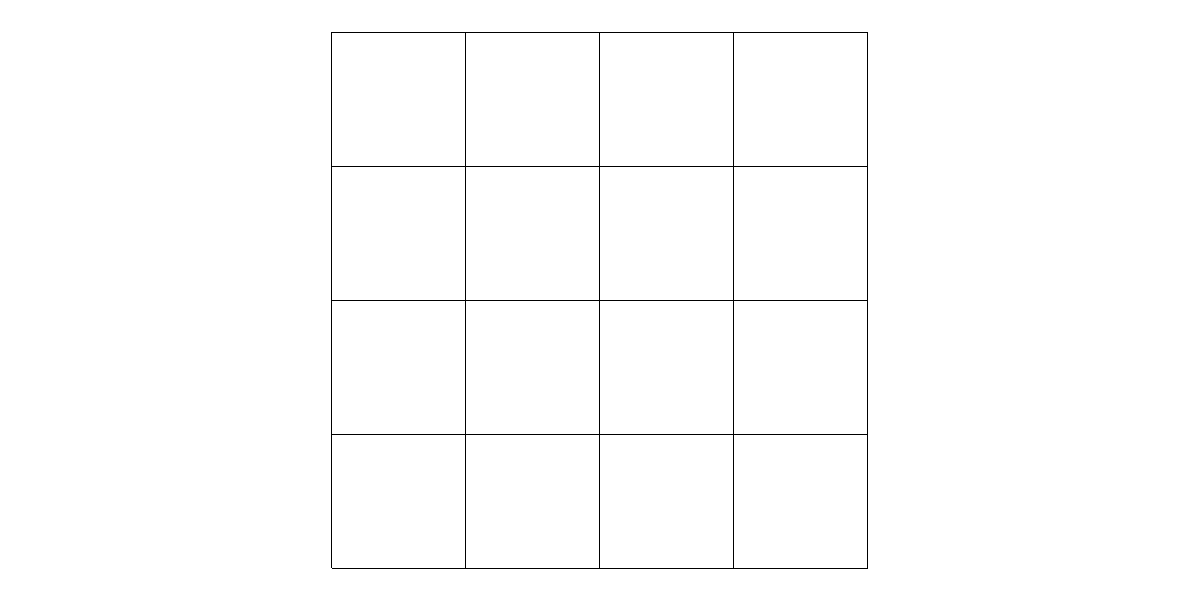

In [229]:
figMesh = glucifer.Figure(figsize=(1200,600),antialias=1)
#figMesh.append( glucifer.objects.Mesh(mesh.subMesh, nodeNumbers=True) )
figMesh.append( glucifer.objects.Mesh(mesh) )
figMesh.show()

In [251]:
p_undeformed = mesh.data.copy()
#p_undeformed

#Get a list of edges (egde represented by a tuple of nodes)
edges = node_neighbours(mesh)

#Get uniform edge_rest_lengths array from mesh
edge_rest_lengths = compute_edge_lengths(p_undeformed, edges)

In [252]:
p_undeformed.shape

(25, 2)

In [253]:
dx = (mesh.maxCoord[0] - mesh.minCoord[0])/ mesh.elementRes[0]
dx 

0.25

In [254]:
def eulerian_mesh_density(dx, x, y):
    return dx + (dx*0.1*(np.cos(np.pi*x))) + (dx*0.1*(np.cos(np.pi*y)))


In [255]:
max(edge_rest_lengths)/min(edge_rest_lengths)

1.159232870629239

In [256]:
eulerian_mesh_density(dx, 0.3, 0.3)

0.27938926261462371

In [257]:
for i in range(len(edges)):
    x0, y0 = mesh.data[edges[i][0]]
    x1, y1 = mesh.data[edges[i][1]]
    x = (x1 + x0)/2.
    y = (y1 + y0)/2.
    #print(x,y)
    edge_rest_lengths[i] = eulerian_mesh_density(dx, x, y)
    

In [258]:
for index, coord in enumerate(mesh.data):
    densityField.data[index] = eulerian_mesh_density(dx, coord[0], coord[1])


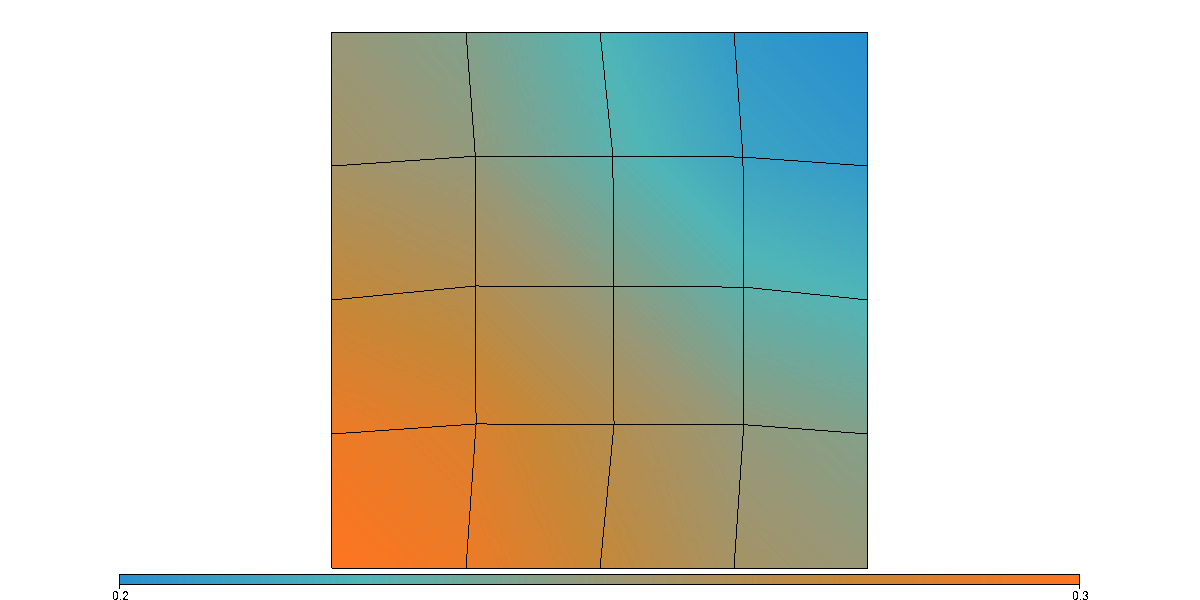

In [259]:
figMesh = glucifer.Figure(figsize=(1200,600),antialias=1)
figMesh.append( glucifer.objects.Surface(mesh, densityField))
figMesh.append( glucifer.objects.Mesh(mesh) )
figMesh.show()

In [260]:
#Perturb the equilibrium sring length in the x direction 

#for index, value in enumerate(edges):
    #print index, value
#    upper_node = max(value)
#    edge_rest_lengths[index] += (0.5*edge_rest_lengths[0]*mesh.data[upper_node, 0])

In [261]:
p_initial = p_undeformed.copy()

#constraints = mesh

Walls = mesh.specialSets['AllWalls_VertexSet']
constraints = mesh.data[Walls.data,:] #is there a cleaner way to extract these?
constraints = zip(Walls, constraints)

In [262]:
p_solution = static_solution( p_initial, edges, edge_rest_lengths, constraints )
#p_solution

-- iteration 0 --
| F( p_n ) |^2: 0.0153950474632
| p_n+1 - p_n |^2: 6.35586597695e-06


In [263]:
#p_solution

In [264]:
with mesh.deform_mesh():
    mesh.data[:] = p_solution[:]


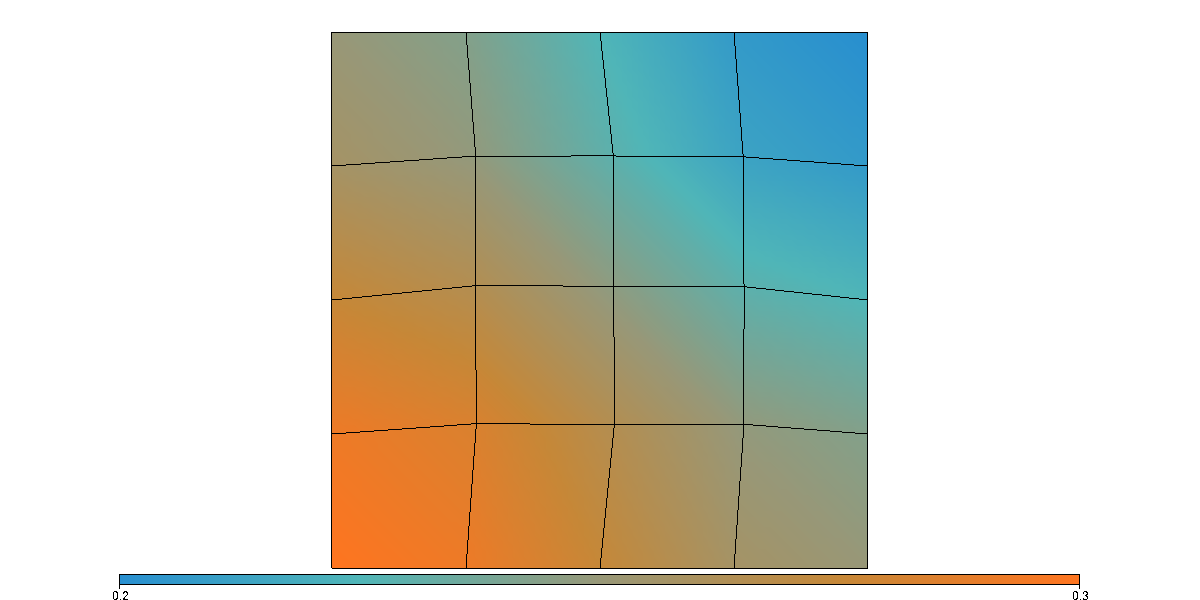

In [265]:
figMesh.show()

In [133]:
def prolong_lin(a):
    pshape = (2*np.shape(a)[0]-1, 2*np.shape(a)[1]-1)
    p=np.empty(pshape,float)
    p[0::2,0::2] = a[0:,0:]
    p[1:-1:2, 0::2] = 0.5*(a[0:-1,0:] + a[1:,0:])
    p[0::2, 1:-1:2] = 0.5*(a[0:,0:-1] + a[0:,1:])
    p[1:-1:2, 1:-1:2] = 0.25*(a[0:-1,0:-1] + a[1:,0:-1] + 
                             a[0:-1,1:] + a[1:,1:] )
    return p

In [134]:
mesh.data.shape

(25, 2)

In [135]:
md1 = mesh.data[:,0].copy()
mesh1array = md1.reshape(mesh.elementRes[0] +1, mesh.elementRes[1] +1)

In [136]:
mesh1array.shape

(5, 5)

In [137]:
finex = prolong_lin(mesh1array)

In [138]:
mesh2 = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (finex.shape[0] -1, finex.shape[1] -1), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.))

In [139]:
md2 = mesh2.data.copy()
mesh2array = md2.reshape(2, mesh2.elementRes[0] +1, mesh2.elementRes[1] +1)

In [140]:
with mesh2.deform_mesh():
    mesh2.data[:,0] = finex.reshape(mesh2.data.shape[0])


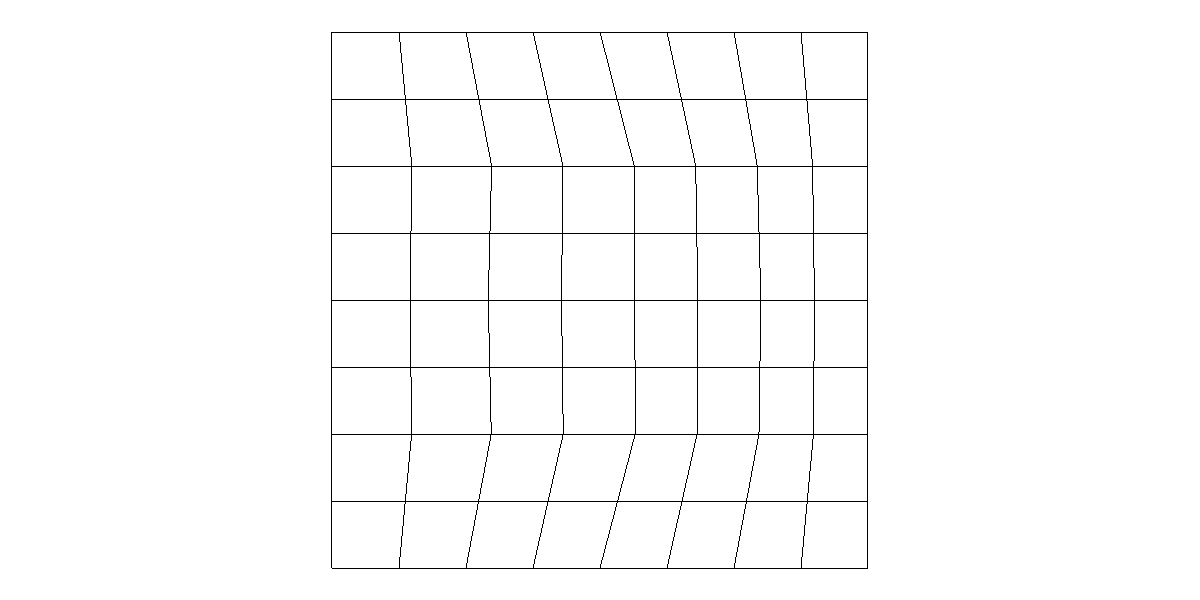

In [141]:
figMesh = glucifer.Figure(figsize=(1200,600),antialias=1)
#figMesh.append( glucifer.objects.Mesh(mesh.subMesh, nodeNumbers=True) )
figMesh.append( glucifer.objects.Mesh(mesh2) )
figMesh.show()

In [158]:
densityField = uw.mesh.MeshVariable( mesh=mesh2, nodeDofCount=1)


In [159]:
p_undeformed = mesh2.data.copy()
#p_undeformed

#Get a list of edges (egde represented by a tuple of nodes)
edges = node_neighbours(mesh2)

#Get uniform edge_rest_lengths array from mesh
edge_rest_lengths = compute_edge_lengths(p_undeformed, edges)

In [166]:
for index, coord in enumerate(mesh2.data):
    densityField.data[index] = eulerian_mesh_density(dx, coord[0], coord[1])

In [167]:
dx = (mesh2.maxCoord[0] - mesh2.minCoord[0])/ mesh2.elementRes[0]
dx 

0.125


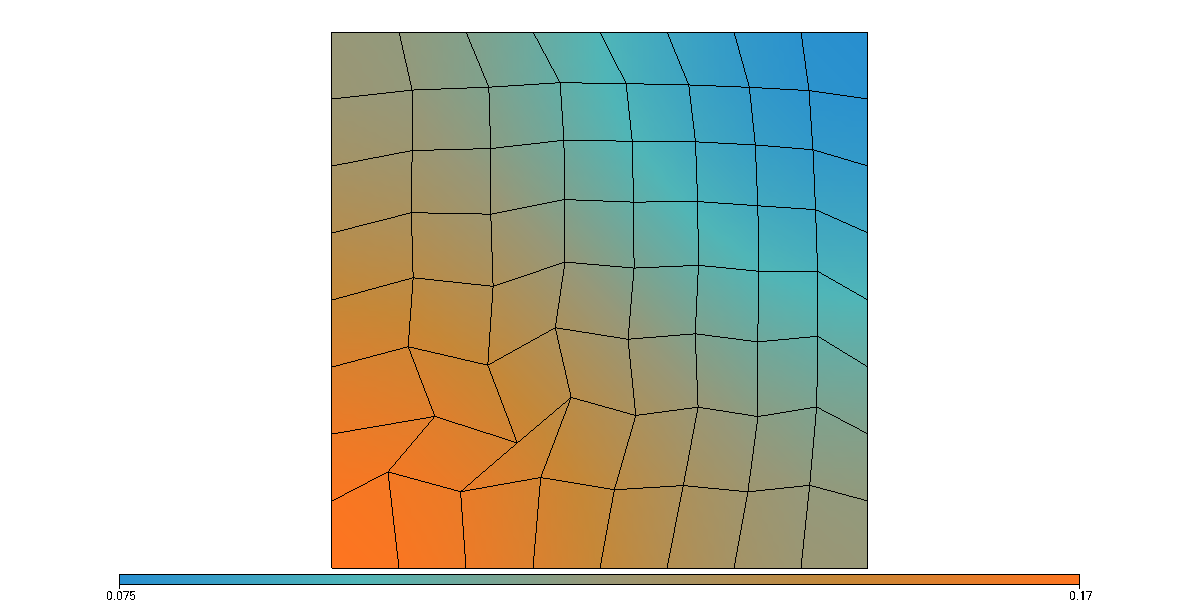

In [168]:
figMesh = glucifer.Figure(figsize=(1200,600),antialias=1)
figMesh.append( glucifer.objects.Surface(mesh2, densityField))
figMesh.append( glucifer.objects.Mesh(mesh2) )
figMesh.show()

In [169]:
for i in range(len(edges)):
    x0, y0 = mesh2.data[edges[i][0]]
    x1, y1 = mesh2.data[edges[i][1]]
    x = (x1 + x0)/2.
    y = (y1 + y0)/2.
    #print(x,y)
    edge_rest_lengths[i] = eulerian_mesh_density(dx, x, y)
    

In [170]:
(1/1000.)*np.random.rand(1)[0]

0.0009303162624759528

In [171]:
#Perturb the equilibrium sring length in the x direction 

#for index, value in enumerate(edges):
#    #print index, value
#    upper_node = max(value)
#    edge_rest_lengths[index] += (1/1000.)*np.random.rand(1)[0]

In [172]:
p_initial = p_undeformed.copy()

#constraints = mesh

Walls = mesh2.specialSets['AllWalls_VertexSet']
constraints = mesh2.data[Walls.data,:] #is there a cleaner way to extract these?
constraints = zip(Walls, constraints)

In [173]:
def static_solution( p, edges, edges_rest_lengths, constraints, verbose = True ):
    '''
    Given a list of points 'p' as an n-by-2 array, a list of (i,j) pairs 'edges' denoting an edge
    between points p[i] and p[j], a list of rest lengths (one for each edge in 'edges'),
    and a list of position constraints (i, position) denoting p[i] = position,
    uses Newton's method to solve for the positions where the forces are all zero.

    NOTE: 'edges' must not have both (i,j) and (j,i)
    '''

    XSTEP_THRESHOLD = 1e-5
    F_THRESHOLD = 1e-8
    MAX_ITERATIONS = 100

    p_n = p.copy().flatten()
    dim = p.shape[1]

    constrain_rows = []
    for i, p_val in constraints:
        p_n[ i*dim : (i+1) * dim ] = p_val
        constrain_rows.extend( range( i*dim, (i+1) * dim ) )

    iteration = 0
    while True:
        if verbose: print '-- iteration', iteration, '--'
        iteration += 1

        Jp_n = J( p_n.reshape( p.shape ), edges, edges_rest_lengths )
        Fp_n = F( p_n.reshape( p.shape ), edges, edges_rest_lengths )
        mag2_Fp_n = sum( Fp_n ** 2 )
        if verbose: print '| F( p_n ) |^2:', mag2_Fp_n
        if mag2_Fp_n < F_THRESHOLD: break

        constrain_system( Jp_n, Fp_n, constrain_rows )

        # p_n_p_1 = p_n - dot( linalg.inv( Jp_n ), Fp_n )
        ## <=> p_n_p_1 - p_n = -linalg.inv( Jp_n ) * Fp_n
        ## <=> p_n - p_n_p_1 = linalg.inv( Jp_n ) * Fp_n
        ## <=> Jp_n * ( p_n - p_n_p_1 ) = Fp_n
        p_negative_delta = linalg.solve( Jp_n, Fp_n )
        ## p_n - ( p_n - p_n_p_1 ) = p_n_p_1
        p_n_p_1 = p_n - 0.1*p_negative_delta

        diff2 = sum( ( p_n_p_1 - p_n ) ** 2 )
        if verbose: print '| p_n+1 - p_n |^2:', diff2
        p_n = p_n_p_1
        if diff2 < XSTEP_THRESHOLD: break

        if iteration >= MAX_ITERATIONS:
            print 'Diverged.'
            return p.copy()
            break

    return p_n.reshape( p.shape )

In [174]:
p_solution = static_solution( p_initial, edges, edge_rest_lengths, constraints )


-- iteration 0 --
| F( p_n ) |^2: 0.0244526086992
| p_n+1 - p_n |^2: 1.97790157996e-05
-- iteration 1 --
| F( p_n ) |^2: 0.0244740205114
| p_n+1 - p_n |^2: 1.57101754919e-05
-- iteration 2 --
| F( p_n ) |^2: 0.0244960620239
| p_n+1 - p_n |^2: 1.25529701332e-05
-- iteration 3 --
| F( p_n ) |^2: 0.0245182917554
| p_n+1 - p_n |^2: 1.00760197835e-05
-- iteration 4 --
| F( p_n ) |^2: 0.0245403440158
| p_n+1 - p_n |^2: 8.11594406725e-06


In [175]:
#p_solution

In [176]:
with mesh2.deform_mesh():
    mesh2.data[:] = p_solution[:]


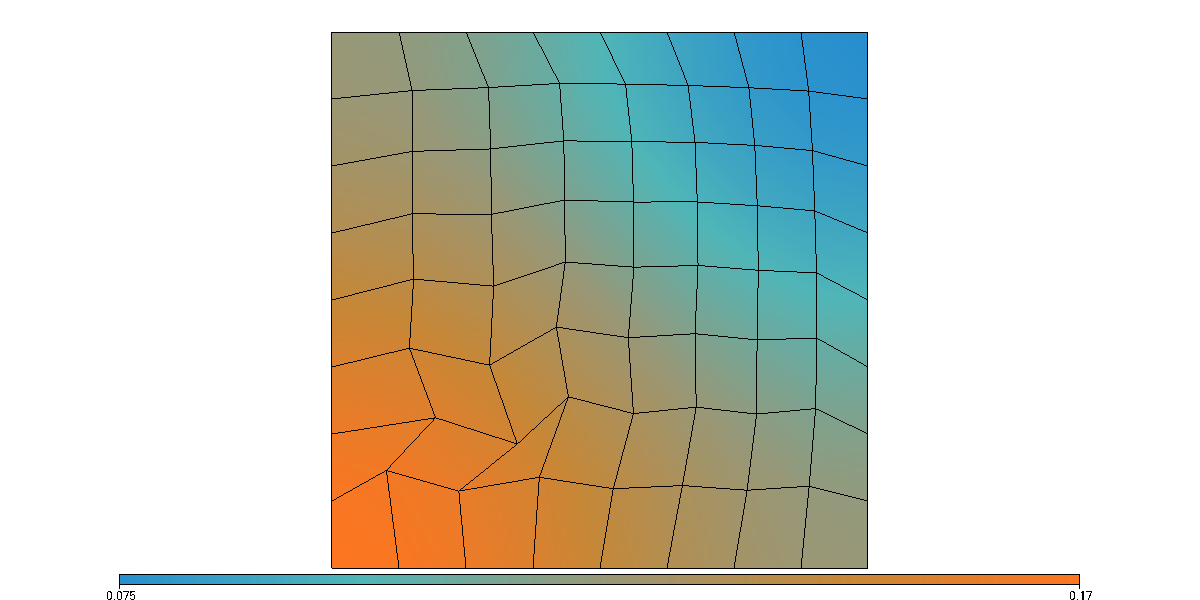

In [177]:
figMesh.show()